In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import xarray as xr
import pickle
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

from brainmodel_utils.core.constants import RIDGECV_ALPHA_CV
from brainmodel_utils.neural_mappers import PercentileNeuralMap
from brainmodel_utils.neural_mappers.utils import (
    generate_train_test_splits,
    convert_dict_to_tuple,
)

from brainmodel_utils.metrics.consistency import get_linregress_consistency,get_linregress_consistency_persphalftrial

DATA_ROOT = "/data/group_data/neuroagents_lab/neural_datasets/zfa_data"

#from zfa.core.default_dirs import (
#    BASE_DIR,
#    NEURAL_TRIALS_PATH,
#    GLIAL_TRIALS_PATH,
#    INTER_ANIMAL_RESULTS_DIR,
#)

# Ensure PyTorch is using a GPU
#if not torch.cuda.is_available():
    #raise RuntimeError("PyTorch cannot find a GPU!")

#device = torch.device("cuda:0")



In [3]:
def rbf_kernel(x, x_prime, length_scale=1.0, amplitude=1.0):
    """
    Compute the RBF kernel between x and x_prime.
    """
    return amplitude**2 * np.exp(-0.5 * np.sum((x - x_prime)**2) / length_scale**2)

def compute_covariance_matrix(X, kernel_func, length_scale=1.0, amplitude=1.0):
    """
    Compute the covariance matrix for given X using specified kernel.
    """
    num_points = X.shape[0]
    K = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            K[i, j] = kernel_func(X[i], X[j], length_scale, amplitude)
    return K

def sample_gaussian_process(X, mean_values, kernel_func, num_samples=1, length_scale=1.0, amplitude=1.0):
    """
    Generate samples from a Gaussian Process with the specified mean values and kernel functions.
    """
    covariance_matrix = compute_covariance_matrix(X, kernel_func, length_scale, amplitude)

    # Ensure the covariance matrix is positive definite for Cholesky decomposition
    L = cholesky(covariance_matrix + 1e-6*np.eye(len(X)), lower=True)

    # Generate samples
    f_samples = []
    for _ in range(num_samples):
        u = np.random.normal(size=(len(X),))
        f_sample = mean_values + np.dot(L, u)
        f_samples.append(f_sample)

    return np.array(f_samples)

In [4]:
def load_data_tensors():
    # loads both neural and glial tensors

    print(" ---Loading data tensors---  ")

    with open(GLIAL_TRIALS_PATH, "rb") as handle:
        glial_trials = pickle.load(handle)
        glial_brain_data = glial_trials["tensors"]

    with open(NEURAL_TRIALS_PATH, "rb") as handle:
        neural_trials = pickle.load(handle)
        neural_brain_data = neural_trials["tensors"]

    return neural_brain_data, glial_brain_data

# load in targets
neural_brain_data, glial_brain_data = load_data_tensors()

 ---Loading data tensors---  


NameError: name 'GLIAL_TRIALS_PATH' is not defined

In [13]:
ANIMALS = list(neural_brain_data.keys())
target_animal = ANIMALS[1]
source_animal = ANIMALS[0]
source_brain_data = glial_brain_data[source_animal]#[:,:,0:1000]
target_brain_data = glial_brain_data[target_animal][:,:,0:5000]


In [14]:
#generate gaussian process around source mean response

X = np.asarray(source_brain_data.coords['time']).reshape(-1, 1)

#X = np.linspace(0, 10, 200).reshape(-1, 1)
mean_time_series = np.asarray(source_brain_data.mean(dim = 'trials').mean(dim = 'units'))
samples = sample_gaussian_process(X, mean_time_series, rbf_kernel, num_samples=len(source_brain_data.coords['units']),length_scale = 1.0,amplitude=1e-3)

coords_sample_source = {
    "time": source_brain_data.coords['time'],    # replace with your actual coordinates
    "units": source_brain_data.coords['units']   # replace with your actual coordinates
}


sample_source_x_arr = xr.DataArray(samples.T, dims=("time", "units"), coords = coords_sample_source)


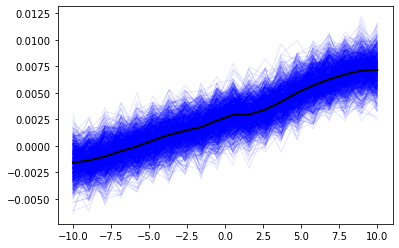

In [12]:
for sample in samples:
    plt.plot(X, sample,alpha = 0.1,color = 'b',linewidth = 1)
plt.plot(X,mean_time_series,color = 'k',linewidth = 2)

In [15]:
map_kwargs = {"map_type": "percentile"}
# turn it into immutable tuple to store as a key
map_kwargs_key = convert_dict_to_tuple(map_kwargs)

dim_trials = 60
dim_times = 20
dim_units_source = 10
dim_units_target = 5*1000

window_size = 10


source_resp = np.random.normal(0,1,size = (dim_trials,dim_times,dim_units_source))
#target_resp = np.random.normal(0,1,size = (dim_trials,dim_times,dim_units_target))


coords_source = {
    "trials": np.arange(dim_trials),  # replace with your actual coordinates
    "time": np.linspace(-window_size,window_size,dim_times),    # replace with your actual coordinates
    "units": np.arange(dim_units_source)   # replace with your actual coordinates
}

# coords_target = {
#     "trials": np.arange(dim_trials),  # replace with your actual coordinates
#     "time": np.linspace(-window_size,window_size,dim_times),    # replace with your actual coordinates
#     "units": np.arange(dim_units_target)   # replace with your actual coordinates
# }

#source_resp = xr.DataArray(source_resp, dims=("trials", "time", "units"), coords = coords_source)
#target_resp = xr.DataArray(target_resp, dims=("trials", "time", "units"), coords = coords_target)
source_resp = sample_source_x_arr
target_resp = target_brain_data

results = get_linregress_consistency(
    source=source_resp,
    target=target_resp,
    map_kwargs=map_kwargs,
    num_bootstrap_iters=1,
    num_parallel_jobs=1,
    splits=None,
    train_frac=0.5,
    num_train_test_splits=5,
)



In [16]:
#den = (results['test']['r_xx_sb'] * results['test']['r_yy_sb']) ** 0.5
#results['test']['r_xy_sb']
np.nanmedian(results['test']['r_xy_n_sb'])

0.6477896092678654

In [ ]:
source_brain_data = neural_brain_data[source_animal]
target_brain_data = glial_brain_data[source_animal][:,:,0:5000]

X = source_brain_data.mean(dim = 'trials')
Y = target_brain_data.mean(dim = 'trials')

# First, remove column means
X_ = X - X.mean(axis=0)
Y_ = Y - Y.mean(axis=0)

# Second, normalize each column vector to norm 1
X_ = X_ / np.linalg.norm(X_, axis=0)
Y_ = Y_ / np.linalg.norm(Y_, axis=0)


In [ ]:
corrs = np.dot(X_.T, Y_)

In [ ]:

percentile_values = np.nanpercentile(corrs, axis = 0, q = 100)

argmax_values = np.argmax(corrs,axis = 0)
#argmax_values == corrs[:,argmax_inds]

In [ ]:
#np.dot(Y_[:,0],X_[:,argmax_values[0]])
np.dot(Y_[:,3],X_[:,argmax_values[3]])

0.9779426

Text(0.5, 1.0, 'Normalized Source Neural $\\rightarrow$ Target Glia Mapping')

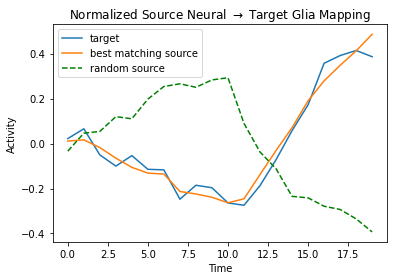

In [ ]:
target_ind = 2
x_best = X_[:,argmax_values[target_ind]]
x_random = X_[:,2]
y = Y_[:,target_ind]

plt.plot(y,label = 'target')
plt.plot(x_best,label = 'best matching source')
plt.plot(x_random,'g--',label = 'random source')

plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()

plt.title(r'Normalized Source Neural $\rightarrow$ Target Glia Mapping')

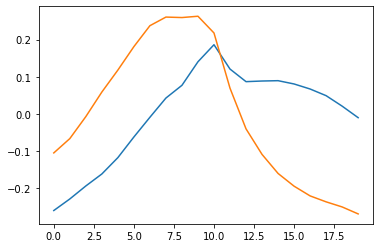

In [ ]:
plt.plot(np.mean(Y_,axis = 1));
plt.plot(np.mean(X_,axis = 1));

In [ ]:
print(np.dot(x,y))
print(percentile_values[target_ind])

0.12975739
0.9464285373687744


-0.1923187566726228


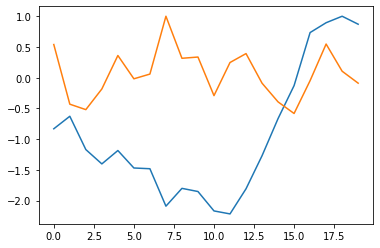

In [ ]:


mean_target = target_resp[:,:,0].mean('trials')
mean_source = source_resp[:,:,2].mean('trials')

print(np.corrcoef(mean_target,mean_source)[0,1])
plt.plot(mean_source/np.max(mean_source))
plt.plot(mean_target/np.max(mean_target))

array([[1.        , 0.20517201],
       [0.20517201, 1.        ]])

In [ ]:
source_resp

<xarray.DataArray (trials: 60, time: 20, units: 10)>
array([[[-0.10559604,  1.03596997, -0.36358034, ..., -0.32475052,
          0.48188884, -0.02698053],
        [ 1.18920434, -0.13989527, -0.07130042, ...,  0.07747989,
          1.79595816, -0.65491137],
        [-0.48407706, -0.73685347,  0.16460317, ...,  0.08055833,
          0.59692087,  0.43201697],
        ...,
        [ 0.73449348,  0.11078365, -1.29951938, ..., -0.97196151,
         -0.52085572, -0.40933609],
        [ 1.60242529, -1.04676361,  0.23726555, ...,  0.11259733,
          1.62327619,  1.22207025],
        [-0.59985714, -0.6568941 ,  0.37264422, ..., -0.75697279,
         -1.05650375, -0.77834412]],

       [[-0.13372495,  0.16205494, -0.63411126, ..., -0.21690008,
          0.25232944, -0.31662527],
        [-0.60323007, -0.5288456 , -0.31573043, ..., -0.22240645,
          0.21939535,  0.09897465],
        [-0.35624585, -1.3899959 , -1.88158232, ...,  0.59671086,
          0.46522979, -0.53737881],
...
        [ 0.20570088, -0.33006886,  1.03213429, ...,  1.49442488,
         -0.30628323,  0.24623159],
        [ 0.12248119,  0.0592619 , -1.15878979, ..., -0.66042996,
          2.27966415,  0.35297427],
        [-1.83526657, -0.03591112,  0.76823695, ...,  0.48421667,
         -0.13847969,  1.58852991]],

       [[ 1.43403203,  1.6509142 ,  1.47541556, ..., -0.34305869,
          0.43237613, -1.11030556],
        [ 0.72026328, -2.29698194,  1.9125878 , ..., -0.19639233,
          0.15694878,  0.15293758],
        [-0.07324936,  2.81802236,  0.11761297, ..., -2.24334949,
         -0.59033101,  0.44922782],
        ...,
        [ 1.05176661, -0.07005447,  0.01906903, ..., -0.06284759,
          0.14252686,  1.09990048],
        [ 0.0953378 ,  0.14251258,  0.12870116, ..., -0.11447224,
          0.16264848,  0.02490313],
        [-0.58594603, -0.13109222,  0.01189689, ...,  1.84270602,
          0.11490721, -0.72757551]]])
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
  * time     (time) float64 -10.0 -8.947 -7.895 -6.842 ... 7.895 8.947 10.0
  * units    (units) int64 0 1 2 3 4 5 6 7 8 9

In [ ]:
np.nanmedian(results['test']['r_xy_n_sb'])

-0.2389114125834585

In [ ]:
results['test']


defaultdict(list,
            {'r_xy_n_sb': <xarray.DataArray (trial_bootstrap_iters: 1, train_test_splits: 5, units: 1000)>
             array([[[        nan,         nan,  0.11750893, ...,         nan,
                      -4.9717304 ,  0.59329723],
                     [-0.63266471,  0.1551755 ,         nan, ...,         nan,
                      -0.44215431,         nan],
                     [-0.39796361,         nan,         nan, ...,         nan,
                      -0.17672955,         nan],
                     [        nan, -0.61547742,         nan, ...,         nan,
                              nan,         nan],
                     [        nan,         nan, -1.50198845, ...,         nan,
                              nan,  0.26621645]]])
             Coordinates:
               * units    (units) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
             Dimensions without coordinates: trial_bootstrap_iters, train_test_splits,
             'r_xx': <xarr

In [ ]:
# Random data generation
size = 1000

a_np = np.random.randn(size, size)
b_np = np.random.randn(size, size)

# Convert numpy arrays to PyTorch tensors on GPU
a_torch = torch.tensor(a_np, device=device).float()
b_torch = torch.tensor(b_np, device=device).float()

# Warm-up to move data to GPU and compile any GPU operations
_ = np.dot(a_np, b_np)
_ = torch.mm(a_torch, b_torch)

# Timing numpy dot product
start_time = time.time()
np_result = np.dot(a_np, b_np)
np_time = time.time() - start_time

# Timing PyTorch dot product on GPU
start_time = time.time()
torch_result = torch.mm(a_torch, b_torch)
torch_time = time.time() - start_time

print(f"Numpy dot product time (on CPU): {np_time:.6f} seconds")
print(f"PyTorch dot product time (on GPU): {torch_time:.6f} seconds")

# Optional: compare results to ensure they're approximately equal
# Move the torch result back to CPU and convert to numpy for comparison
torch_result_np = torch_result.cpu().numpy()
assert np.allclose(np_result, torch_result_np, atol=1e-4), "The results are not close enough!"


62.5

In [ ]:
0.3*5

1.5